### Simulation Setup

In [ ]:
!pip install simpy
import pandas as pd
import numpy as np
import simpy
import itertools
import matplotlib.pyplot as plt
from scipy import stats
from tqdm.notebook import tqdm
import os

np.random.seed(42)

In [ ]:
file_path = "inventory_data.xlsx"
df = pd.read_excel(file_path)
# Using a NumPy array (much faster for random sampling inside the simulation loop)
DEMAND_QUANTITIES = df['Demand quantity'].dropna().astype(int).to_numpy()
INTERARRIVAL_TIMES = df['Time elapsed since the arrival of last demand'].dropna().astype(float).to_numpy()

# Simulation constants from the problem statement
COST_ORDER_SETUP = 32.            # Fixed cost of placing an order ($)
COST_ORDER_PER_ITEM = 3.          # Variable cost per item ordered ($)
COST_SHORTAGE_PER_ITEM = 5.       # Monthly cost for each backlogged item ($)
COST_HOLDING_PER_ITEM = 1.        # Monthly cost for each item held in inventory ($)

### InventorySystem Class

This class simulates a single-product inventory system under the **(s, S) policy**:

- When inventory < `s`, an order is placed to raise stock up to `S`.  
- Tracks **ordering, holding, and shortage costs**.  
- Simulates **random demand arrivals**, **demand sizes**, and **lead times**.  
- Core processes:
  - `demand_generator`: generates demand arrivals.  
  - `inventory_reviewer`: checks and places orders.  
  - `place_order`: handles order delivery.  
  - `update_costs`: updates holding/shortage costs.  
  - `cost_recorder`: (optional) records cumulative costs for Welch analysis.  


In [ ]:
class InventorySystem:
    """A simulation of a single product inventory system using the (s, S) policy."""
    def __init__(self, env, s, S, demand_data, interarrival_data, seed,
                 record_series_data=False, sampling_interval=1.0):
        if S <= s:
            raise ValueError("S must be greater than s for the (s, S) policy.")

        # Initialize parameters
        self.env = env
        self.s = s
        self.S = S
        self.demand_data = demand_data
        self.record_series_data = record_series_data
        self.interarrival_data = interarrival_data

        self.rng = np.random.default_rng(seed)

        self.level = S
        self.last_change_time = 0.0

        # Initialize cost trackers
        self.ordering_cost = 0.0
        self.shortage_cost = 0.0
        self.holding_cost = 0.0

        # Start the simulation processes
        self.env.process(self.inventory_reviewer())
        self.env.process(self.demand_generator())

        # Only start the recorder if the flag is True
        if self.record_series_data:
            self.sampling_interval = sampling_interval
            self.cumulative_cost_series = []
            self.history = [(0.0, self.level)]
            self.env.process(self.cost_recorder())

    def cost_recorder(self):
        """Records the cumulative average cost at regular intervals."""
        while True:
            # Wait for the next sampling point
            yield self.env.timeout(self.sampling_interval)

            # Take a non-mutating snapshot of total cost up to now (do not change internal bookkeeping)
            current_total_cost = self.snapshot_total_cost(self.env.now)

            # Avoid division by zero at the very start
            if self.env.now > 0:
                avg_cost = current_total_cost / self.env.now
                self.cumulative_cost_series.append(avg_cost)

    def snapshot_total_cost(self, now=None):
        """
        Returns a snapshot of total cost up to `now` without mutating internal counters.
        This allows the recorder to read cumulative-average values without changing state.
        """
        if now is None:
            now = self.env.now
        time_delta = now - self.last_change_time
        extra_holding = 0.0
        extra_shortage = 0.0
        if time_delta > 0:
            # If there is inventory, add to holding cost (snapshot)
            if self.level > 0:
                extra_holding = self.level * COST_HOLDING_PER_ITEM * time_delta
            # If there is a shortage, add to shortage cost (snapshot)
            elif self.level < 0:
                extra_shortage = abs(self.level) * COST_SHORTAGE_PER_ITEM * time_delta

        return self.ordering_cost + self.holding_cost + self.shortage_cost + extra_holding + extra_shortage

    def demand_generator(self):
        """Generates customer demands by sampling from the provided dataset."""
        while True:
            inter_arrival_time = float(self.rng.choice(self.interarrival_data))

            # Sample demand quantity from the pre-loaded NumPy array.
            demand_size = int(self.rng.choice(self.demand_data))

            # Wait for the next demand event
            yield self.env.timeout(inter_arrival_time)

            # Update costs before changing the inventory level
            # update_costs will advance the bookkeeping to the current time
            self.update_costs(to_time=self.env.now)
            self.level -= demand_size
            self.last_change_time = self.env.now
            if self.record_series_data:
                self.history.append((self.env.now, self.level))

    def inventory_reviewer(self):
        """Reviews inventory at the start of each month and places orders if needed."""
        while True:
            # At the start of the month, check the inventory level
            if self.level < self.s:   #I <s
                # Place an order to bring inventory up to S
                order_quantity = self.S - self.level #Z = S −I

                # update ordering costs
                self.ordering_cost += COST_ORDER_SETUP + (order_quantity * COST_ORDER_PER_ITEM) #32 + 3Z
                # This creates a new, independent order process for each order placed
                self.env.process(self.place_order(order_quantity))

            # Wait for the next monthly review
            yield self.env.timeout(1.0)

    def place_order(self, quantity):
        """Handles the lead time for an order to arrive."""
        # Lead time is Uniform(0.5, 1) month
        lead_time = float(self.rng.uniform(0.5, 1.0))
        yield self.env.timeout(lead_time)

        # Update costs before the order arrives
        self.update_costs(to_time=self.env.now)
        self.level += quantity
        self.last_change_time = self.env.now

        if self.record_series_data:
            self.history.append((self.env.now, self.level))

    def update_costs(self, to_time=None):
        """Updates time-averaged holding and shortage costs since the last event."""
        if to_time is None:
            to_time = self.env.now
        time_delta = to_time - self.last_change_time
        if time_delta > 0:
            # If there is inventory, add to holding cost
            if self.level > 0:
                self.holding_cost += self.level * COST_HOLDING_PER_ITEM * time_delta
            # If there is a shortage, add to shortage cost
            elif self.level < 0:
                self.shortage_cost += abs(self.level) * COST_SHORTAGE_PER_ITEM * time_delta
            # advance the last_change_time to the to_time after accounting
            self.last_change_time = to_time

### Welch’s Method: Data Collection & Plotting

Here we implement **Welch’s graphical procedure** to estimate the warm-up period.

This helps identify and discard the **initial transient** before steady-state analysis.


In [ ]:
def collect_cumulative_avg_data(s, S, num_replications, run_length, sampling_interval,
                                interarrival_data=INTERARRIVAL_TIMES, master_seed=12345):
    """
    Runs multiple replications and collects cumulative average cost data following Welch's setup.
    """
    print(f"--- Collecting cumulative average cost data ({num_replications} replications) ---")
    rng_master = np.random.default_rng(master_seed)
    seeds = rng_master.integers(0, 2**32 - 1, size=num_replications)

    expected_samples = int(run_length / sampling_interval)
    all_replications_data = np.zeros((num_replications, expected_samples), dtype=float)

    for i, seed in enumerate(seeds):
        env = simpy.Environment()
        inv_system = InventorySystem(env, s, S,
                                     demand_data=DEMAND_QUANTITIES,
                                     interarrival_data=interarrival_data,
                                     seed=int(seed),
                                     record_series_data=True,
                                     sampling_interval=sampling_interval)
        env.run(until=run_length)
        inv_system.update_costs(to_time=env.now)

        series = list(inv_system.cumulative_cost_series)

        # Pad or truncate to expected length
        if len(series) == 0:
            padded = [np.nan] * expected_samples
        elif len(series) < expected_samples:
            padded = series + [series[-1]] * (expected_samples - len(series))
        else:
            padded = series[:expected_samples]

        all_replications_data[i, :] = padded

    print("--- Data collection complete ---")
    return all_replications_data


def plot_cumulative_average(replication_data, sampling_interval, suggested_warmup,
                            smooth_window=5, show_percentile_band=True):
    """
    Plots the cumulative average cost for each replication and the ensemble average.
    """
    def moving_average(x, window):
        """Simple moving average (same length as x)."""
        x = np.asarray(x, dtype=float)
        if window <= 1:
            return x
        kernel = np.ones(window)
        sums = np.convolve(x, kernel, mode='same')
        counts = np.convolve(np.ones_like(x), kernel, mode='same')
        return sums / counts

    num_replications, num_observations = replication_data.shape
    time_points = (np.arange(num_observations) + 1) * sampling_interval

    plt.figure(figsize=(14, 8))

    # Replication curves
    for i in range(num_replications):
        rep = replication_data[i, :]
        rep_sm = moving_average(rep, smooth_window)
        plt.plot(time_points, rep_sm, lw=1.2, alpha=0.45,
                 label=f'replication {i+1}' if i < 5 else None)

    # Ensemble average
    grand_average = np.mean(replication_data, axis=0)
    grand_sm = moving_average(grand_average, smooth_window)
    plt.plot(time_points, grand_sm, color='black', lw=2.7,
             label='ensemble average across replications (smoothed)')

    # Interquartile range
    if show_percentile_band:
        lower = np.percentile(replication_data, 25, axis=0)
        upper = np.percentile(replication_data, 75, axis=0)
        lower_sm = moving_average(lower, smooth_window)
        upper_sm = moving_average(upper, smooth_window)
        plt.fill_between(time_points, lower_sm, upper_sm, color='gray', alpha=0.2,
                         label='interquartile range (25%–75%) (smoothed)')

    # Warm-up cutoff
    plt.axvline(x=suggested_warmup, color='red', linestyle='--', lw=2,
                label=f'warm-up cutoff (L={suggested_warmup})')

    plt.title(f'Cumulative Average Inventory Cost Across {num_replications} Replications', fontsize=16)
    plt.xlabel('Month')
    plt.ylabel('Cumulative average cost')
    plt.legend(loc='best', fontsize='small')
    plt.grid(True, which='major', linestyle='--', alpha=0.5)
    plt.show()


--- Collecting cumulative average cost data (10 replications) ---
--- Data collection complete ---


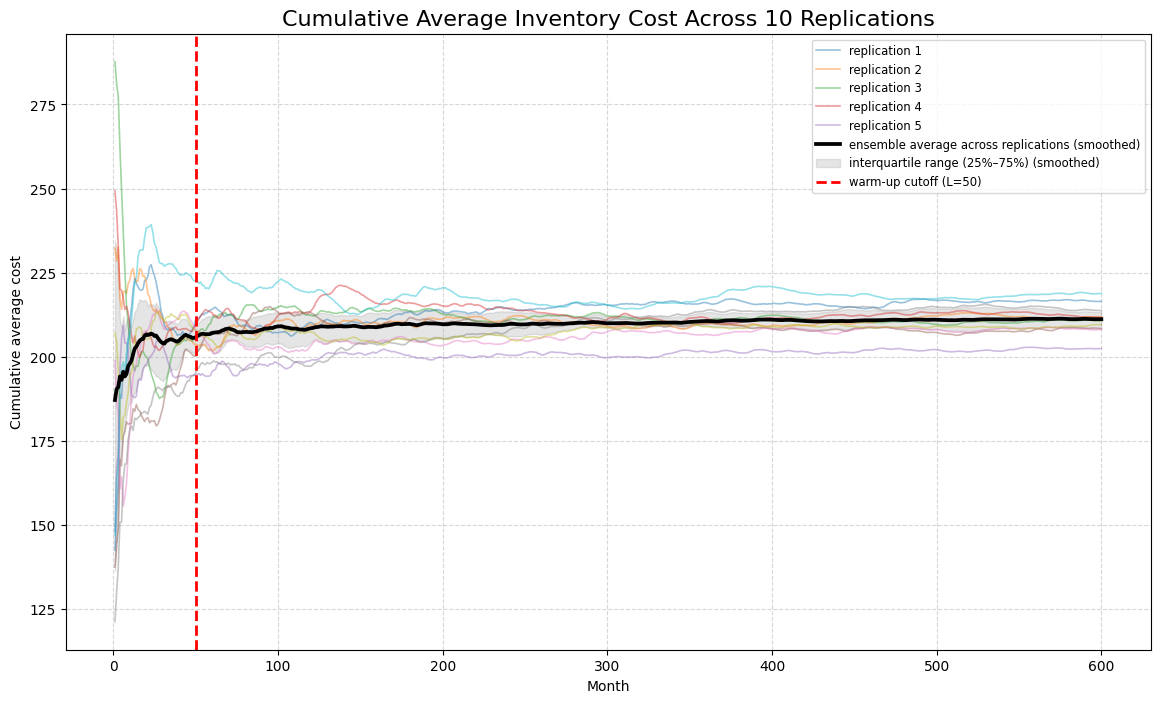

In [ ]:
#Reorder Point
s=50
#Maximum Inventory Level
S=100
# Duration of the simulation (in months)
SIM_LENGTH = 120
#Number of Replications
NUM_REPS = 10
#Warmup Period
WARMUP_L = 50
#Smoothing Windo
SMOOTH_WINDOW = 5
#Sampling Interval
SAMPLING_INT = 1

cum_avg_data = collect_cumulative_avg_data(s, S, NUM_REPS, SIM_LENGTH, SAMPLING_INT)
plot_cumulative_average(cum_avg_data, SAMPLING_INT, WARMUP_L, SMOOTH_WINDOW)


### Single Simulation Run

We implement a procedure to run a **single replication** of the (s, S) inventory system:

- A **warm-up phase** is executed, and all statistics collected during this phase are discarded.  
- After warm-up, cost counters are reset, and the system is run for the **steady-state period**.  
- Average monthly **ordering, holding, shortage, and total costs** are computed over the steady-state horizon.  

An optional plot of inventory level (`plot_inventory_history`) can be generated to visualize system behavior under a chosen (s, S) policy.


In [ ]:
def plot_inventory_history(inventory_system):
    """Displays a step chart of the inventory level over time."""
    if not hasattr(inventory_system, 'history') or not inventory_system.history:
        print("No history data to plot. Rerun with display_chart=True.")
        return
    plt.figure(figsize=(12, 6))
    x_val = [x[0] for x in inventory_system.history]
    y_val = [x[1] for x in inventory_system.history]
    plt.step(x_val, y_val, where='post', label='Inventory Level')
    plt.axhline(y=0, color='red', linestyle='-', linewidth=0.8, label='Shortage threshold')
    plt.axhline(y=inventory_system.s, color='green', linestyle='--', label=f'Reorder Point (s={inventory_system.s})')
    plt.axhline(y=inventory_system.S, color='black', linestyle='--', label=f'Order-up-to Level (S={inventory_system.S})')
    plt.xlabel('Time (Months)')
    plt.ylabel('Units in Inventory')
    plt.title(f'Inventory Level Simulation for (s={inventory_system.s}, S={inventory_system.S})')
    plt.grid(True, which='major', linestyle='--', alpha=0.6)
    plt.legend()
    plt.show()

def run_single_simulation(s, S, sim_length, warm_up_period, display_chart=False,
                          demand_data=DEMAND_QUANTITIES, interarrival_data=INTERARRIVAL_TIMES,
                          sampling_interval=1.0, seed=None):
    """
    Runs one full simulation for a given (s, S) policy.
    """
    # Setup simulation environment
    env = simpy.Environment()

    # Use the provided seed; if none, generate one for a standalone run.
    if seed is None:
        seed = np.random.randint(0, 2**32 - 1)

    # Create the InventorySystem
    inv_system = InventorySystem(env, s, S,
                                 demand_data=demand_data,
                                 interarrival_data=interarrival_data,
                                 seed=int(seed),
                                 record_series_data=display_chart,
                                 sampling_interval=sampling_interval)

    # --- 1. WARM-UP PHASE ---
    # Run the simulation for the warm-up period, but do nothing with the results.
    env.run(until=warm_up_period)

    # --- 2. STEADY-STATE PHASE ---
    # RESET all cost counters to zero. This "deletes" the transient data.
    inv_system.ordering_cost = 0.0
    inv_system.shortage_cost = 0.0
    inv_system.holding_cost = 0.0
    inv_system.last_change_time = env.now

    # Run the simulation for the actual data collection period
    env.run(until=warm_up_period + sim_length)

    # Final cost update to capture any accumulation up to the exact end time
    inv_system.update_costs(to_time=env.now)

    # Calculate and return average monthly costs
    avg_total_cost = float((inv_system.ordering_cost + inv_system.holding_cost + inv_system.shortage_cost) / sim_length)
    avg_ordering_cost = float(inv_system.ordering_cost / sim_length)
    avg_holding_cost = float(inv_system.holding_cost / sim_length)
    avg_shortage_cost = float(inv_system.shortage_cost / sim_length)

    results = {
        's': s,
        'S': S,
        'total_cost': avg_total_cost,
        'ordering_cost': avg_ordering_cost,
        'holding_cost': avg_holding_cost,
        'shortage_cost': avg_shortage_cost
    }

    if display_chart:
        plot_inventory_history(inv_system)

    return results

--- Running a Single Run simulation for (s=50,S=100) with simulation length of 120---


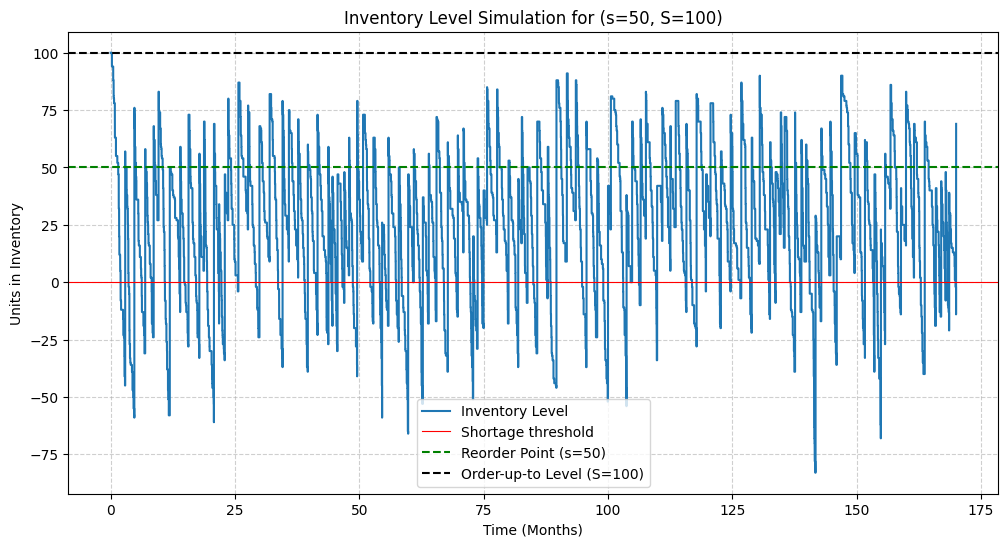


--- Results of Single Run ---simulation for (s=50,S=100) with simulation length of 120---
{'s': 50, 'S': 100, 'total_cost': 211.80088400027003, 'ordering_cost': 162.05, 'holding_cost': 30.061723973795768, 'shortage_cost': 19.689160026474266}


In [ ]:
# --- Run a Single Simulation Example ---

#Reorder Point
s=50
#Maximum Inventory Level
S=100
# Duration of the simulation (in months)
SIM_LENGTH = 120
#Warmup Period
WARM_UP_PERIOD = 50

print(f"--- Running a Single Run simulation for (s={s},S={S}) with simulation length of {SIM_LENGTH}---")
single_run_results = run_single_simulation(
    s, S,
    sim_length=SIM_LENGTH,
    warm_up_period=WARM_UP_PERIOD,
    display_chart=True
)
print(f"\n--- Results of Single Run ---simulation for (s={s},S={S}) with simulation length of {SIM_LENGTH}---")
print(single_run_results)

### Policy Evaluation with Multiple Replications

To compare different (s, S) policies, we extend the simulation to **all valid policy pairs**:

- Each policy `(s, S)` is simulated for **N independent replications** after discarding a warm-up period.  
- The performance measure is the **average monthly total cost** across replications.  
- To quantify statistical reliability, a **95% confidence interval (t-based)** is constructed.   

This enables efficient identification of the **optimal (s, S) policy**.


In [ ]:
def run_all_policies_with_replications(s_values, S_values,
                                      num_replications=10,
                                      warm_up_period=50,
                                      sim_length=120,
                                      sampling_interval=1.0,
                                      master_seed=42):
    """
    Runs simulations for every valid (s, S) combination with multiple replications
    and returns a DataFrame with mean total cost and a 95% CI for each policy.
    """
    all_results = []
    # Create all valid (s, S) policy pairs
    policies = [p for p in itertools.product(s_values, S_values) if p[1] > p[0]]

    # Create a master RNG from the master_seed.
    rng_master = np.random.default_rng(master_seed)
    replication_seeds = rng_master.integers(0, 2**32 - 1, size=num_replications)

    print(f"Policies: {len(policies)}")
    print(f"Parameters: {num_replications} reps, {warm_up_period} month warm-up, {sim_length} month run length")

    for s, S in tqdm(policies, desc="Simulating Policies"):

        # For each policy, run N independent replications (production replications)
        replication_costs = []
        for seed in replication_seeds:
            result = run_single_simulation(s, S,
                                           sim_length=sim_length,
                                           warm_up_period=warm_up_period,
                                           display_chart=False,
                                           demand_data=DEMAND_QUANTITIES,
                                           interarrival_data=INTERARRIVAL_TIMES,
                                           sampling_interval=sampling_interval,
                                           seed=seed)

            # result['total_cost'] is returned (rounded by run_single_simulation)
            replication_costs.append(result['total_cost'])

        replication_costs = np.array(replication_costs, dtype=float)

        # Point estimate and 95% CI (t-based)
        mean_cost = replication_costs.mean()
        if num_replications > 1:
            std_dev = replication_costs.std(ddof=1)
            t_crit = stats.t.ppf(0.975, df=num_replications - 1)
            ci_half_width = t_crit * std_dev / np.sqrt(num_replications)
        else:
            std_dev = 0.0
            ci_half_width = 0.0

        all_results.append({
            's': s,
            'S': S,
            'mean_total_cost': round(float(mean_cost), 2),
            'ci_lower': round(float(mean_cost - ci_half_width), 2),
            'ci_upper': round(float(mean_cost + ci_half_width), 2),
            'ci_width': round(float(2 * ci_half_width), 2)
        })

    return pd.DataFrame(all_results)


In [ ]:
# Define the parameter grid for the (s, S) policies
s_values = range(20, 101, 10)
S_values = range(40, 201, 10)

# Duration of the simulation (in months)
SIM_LENGTH = 450
#Warmup Period
WARM_UP_PERIOD = 50

# Define the different numbers of replications to test
replications_to_run = [1, 20, 50, 100]

# A dictionary to hold the results DataFrame for each experiment run
all_experiment_results = {}

for num_reps in replications_to_run:
    print("\n" + "="*60)
    print(f"--- STARTING EXPERIMENT RUN WITH {num_reps} REPLICATIONS ---")
    print("="*60)

    # Run the full experiment for the current number of replications
    results_df = run_all_policies_with_replications(
        s_values=s_values,
        S_values=S_values,
        num_replications=num_reps,
        warm_up_period=WARM_UP_PERIOD,
        sim_length=SIM_LENGTH,
        sampling_interval=1.0,
        master_seed=42
    )

    # Store the dataframe in our dictionary
    all_experiment_results[num_reps] = results_df

    # --- Save the results to a unique CSV file ---
    output_filename = f"results_rep_{num_reps}.csv"
    results_df.to_csv(output_filename, index=False)

    # --- Find and display the optimal policy for this run ---
    if not results_df.empty:
        optimal_policy = results_df.loc[results_df['mean_total_cost'].idxmin()]
        print("\n--- Optimal Policy Found ---")
        print(f"(s, S) = ({int(optimal_policy['s'])}, {int(optimal_policy['S'])})")
        print(f"Mean Cost: ${optimal_policy['mean_total_cost']:.2f}, "
              f"95% CI: (${optimal_policy['ci_lower']:.2f}, ${optimal_policy['ci_upper']:.2f})")

        # --- Display the top 5 best policies for this run ---
        print("\n--- Top 5 Policies (sorted by Mean Total Cost) ---")
        top_5_policies = results_df.sort_values(by='mean_total_cost').head(5)
        print(top_5_policies.to_string(index=False, float_format="%.2f"))
    else:
        print("No results generated for this run.")

print("\n" + "="*60)
print("--- ALL EXPERIMENTS COMPLETED ---")
print("="*60)


--- STARTING EXPERIMENT RUN WITH 10 REPLICATIONS ---
Policies: 125
Parameters: 10 reps, 50 month warm-up, 120 month run length


Simulating Policies:   0%|          | 0/125 [00:00<?, ?it/s]


--- Optimal Policy Found ---
(s, S) = (60, 90)
Mean Cost: $210.45, 95% CI: ($206.12, $214.78)

--- Top 5 Policies (sorted by Mean Total Cost) ---
 s   S  mean_total_cost  ci_lower  ci_upper  ci_width
60  90           210.45    206.12    214.78      8.67
60 100           210.94    205.97    215.91      9.94
50 100           211.01    206.38    215.64      9.26
50 110           211.21    206.92    215.50      8.58
50  90           211.42    205.76    217.08     11.32

--- STARTING EXPERIMENT RUN WITH 20 REPLICATIONS ---
Policies: 125
Parameters: 20 reps, 50 month warm-up, 120 month run length


Simulating Policies:   0%|          | 0/125 [00:00<?, ?it/s]


--- Optimal Policy Found ---
(s, S) = (60, 90)
Mean Cost: $210.07, 95% CI: ($207.37, $212.77)

--- Top 5 Policies (sorted by Mean Total Cost) ---
 s   S  mean_total_cost  ci_lower  ci_upper  ci_width
60  90           210.07    207.37    212.77      5.40
50 100           210.80    207.45    214.16      6.72
50 110           210.90    208.17    213.63      5.46
60 100           210.91    207.58    214.24      6.66
50  90           211.09    207.27    214.92      7.65

--- STARTING EXPERIMENT RUN WITH 50 REPLICATIONS ---
Policies: 125
Parameters: 50 reps, 50 month warm-up, 120 month run length


Simulating Policies:   0%|          | 0/125 [00:00<?, ?it/s]


--- Optimal Policy Found ---
(s, S) = (50, 90)
Mean Cost: $210.06, 95% CI: ($207.66, $212.46)

--- Top 5 Policies (sorted by Mean Total Cost) ---
 s   S  mean_total_cost  ci_lower  ci_upper  ci_width
50  90           210.06    207.66    212.46      4.80
60 100           210.11    208.05    212.16      4.12
60  90           210.19    208.31    212.07      3.76
50 110           210.42    208.39    212.45      4.06
50 100           210.77    208.46    213.09      4.63

--- STARTING EXPERIMENT RUN WITH 100 REPLICATIONS ---
Policies: 125
Parameters: 100 reps, 50 month warm-up, 120 month run length


Simulating Policies:   0%|          | 0/125 [00:00<?, ?it/s]


--- Optimal Policy Found ---
(s, S) = (50, 90)
Mean Cost: $210.09, 95% CI: ($208.57, $211.62)

--- Top 5 Policies (sorted by Mean Total Cost) ---
 s   S  mean_total_cost  ci_lower  ci_upper  ci_width
50  90           210.09    208.57    211.62      3.05
60  90           210.16    208.90    211.41      2.50
60 100           210.28    208.97    211.59      2.62
50 100           210.54    208.99    212.10      3.11
50 110           210.72    209.22    212.22      3.00

--- STARTING EXPERIMENT RUN WITH 250 REPLICATIONS ---
Policies: 125
Parameters: 250 reps, 50 month warm-up, 120 month run length


Simulating Policies:   0%|          | 0/125 [00:00<?, ?it/s]


--- Optimal Policy Found ---
(s, S) = (60, 90)
Mean Cost: $210.31, 95% CI: ($209.56, $211.06)

--- Top 5 Policies (sorted by Mean Total Cost) ---
 s   S  mean_total_cost  ci_lower  ci_upper  ci_width
60  90           210.31    209.56    211.06      1.50
50  90           210.55    209.64    211.45      1.81
60 100           210.57    209.79    211.35      1.56
50 100           210.59    209.69    211.49      1.80
50 110           210.93    210.07    211.80      1.73

--- STARTING EXPERIMENT RUN WITH 500 REPLICATIONS ---
Policies: 125
Parameters: 500 reps, 50 month warm-up, 120 month run length


Simulating Policies:   0%|          | 0/125 [00:00<?, ?it/s]


--- Optimal Policy Found ---
(s, S) = (50, 90)
Mean Cost: $209.88, 95% CI: ($209.27, $210.50)

--- Top 5 Policies (sorted by Mean Total Cost) ---
 s   S  mean_total_cost  ci_lower  ci_upper  ci_width
50  90           209.88    209.27    210.50      1.22
60  90           210.01    209.49    210.52      1.03
60 100           210.05    209.53    210.58      1.05
50 100           210.09    209.49    210.68      1.19
50 110           210.56    209.97    211.15      1.18

--- STARTING EXPERIMENT RUN WITH 1000 REPLICATIONS ---
Policies: 125
Parameters: 1000 reps, 50 month warm-up, 120 month run length


Simulating Policies:   0%|          | 0/125 [00:00<?, ?it/s]


--- Optimal Policy Found ---
(s, S) = (50, 90)
Mean Cost: $209.76, 95% CI: ($209.33, $210.19)

--- Top 5 Policies (sorted by Mean Total Cost) ---
 s   S  mean_total_cost  ci_lower  ci_upper  ci_width
50  90           209.76    209.33    210.19      0.86
50 100           209.79    209.38    210.21      0.83
60 100           209.92    209.55    210.30      0.74
60  90           210.00    209.63    210.36      0.73
50 110           210.36    209.95    210.77      0.82

--- ALL EXPERIMENTS COMPLETED ---


### Contour Plot of Mean Monthly Inventory Cost

We use a **contour plot** to visualize how the mean monthly cost varies across different (s, S) policy combinations:   

This visualization provides an **intuitive 2D overview** of the policy space, making it easier to identify cost valleys and compare alternatives.


In [ ]:
from mpl_toolkits.mplot3d import Axes3D

def plot_contour(all_experiment_results, num_reps):
    """Generates a contour plot for a specific experiment run."""
    try:
        results_df = all_experiment_results[num_reps]
    except KeyError:
        print(f"Error: No results found for {num_reps} replications.")
        return

    # Find the optimal policy within this specific DataFrame
    optimal_policy = results_df.loc[results_df['mean_total_cost'].idxmin()]

    # --- Data Preparation for Plotting ---
    pivot_data = results_df.pivot(index='s', columns='S', values='mean_total_cost')
    X = pivot_data.columns.values
    Y = pivot_data.index.values
    Z = pivot_data.values

    # --- Generate Contour Plot ---
    plt.figure(figsize=(12, 7))
    plt.title(f'Contour Plot of Mean Monthly Cost', fontsize=16)
    plt.xlabel('Order-up-to Level (S)', fontsize=12)
    plt.ylabel('Reorder Point (s)', fontsize=12)

    contours = plt.contour(X, Y, Z, 15, cmap='viridis')
    plt.clabel(contours, inline=True, fmt='%1.1f', fontsize=9)
    plt.grid(color='gray', linestyle='--', linewidth=0.5)

    # Add a marker for the optimal point
    plt.plot(optimal_policy['S'], optimal_policy['s'], 'rX', markersize=12,
             label=f"Optimal Point ({int(optimal_policy['s'])}, {int(optimal_policy['S'])})")

    plt.legend()
    plt.show()

--- Generating Contour Plot for the 100-replication experiment ---


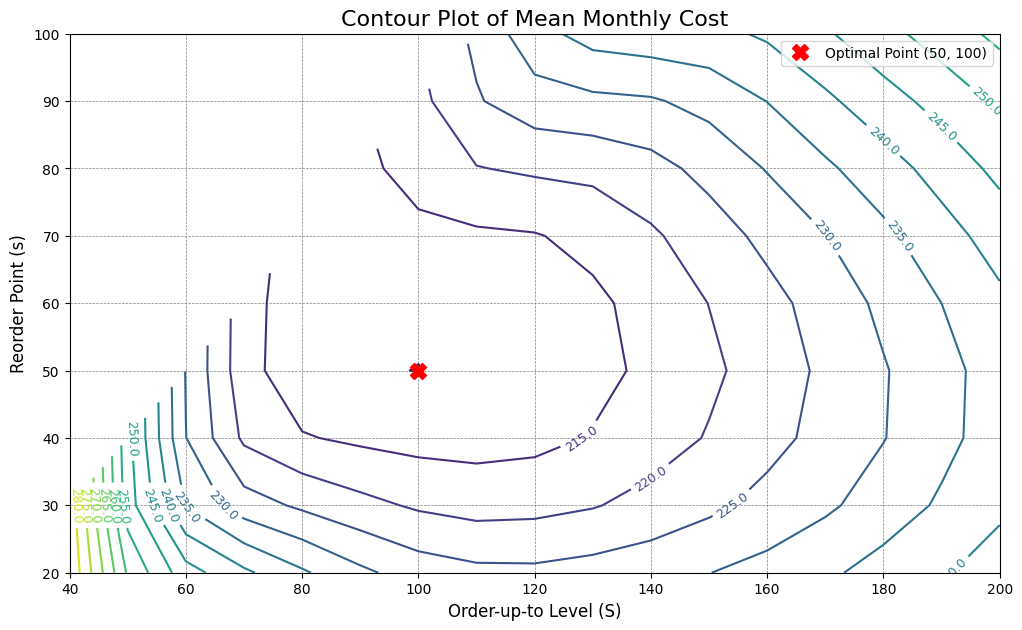

In [ ]:
# If 'all_experiment_results' is not populated with simulation runs we can also read from the csv files.
# For example:
# all_experiment_results[10] = pd.read_csv("results_rep_10.csv")
# all_experiment_results[1000] = pd.read_csv("results_rep_1000.csv")

num_reps_to_plot = 100

print(f"--- Generating Contour Plot for the {num_reps_to_plot}-replication experiment ---")

if num_reps_to_plot in all_experiment_results:
    plot_contour(all_experiment_results, num_reps_to_plot)
else:
    print(f"No data available for {num_reps_to_plot} replications.")

### 3D Response Surface for Inventory Cost

To visualize how inventory cost varies with the (s, S) policy, we generate a **3D response surface**:

This plot highlights the **landscape of costs** across different policies.  
Regions with **lower cost (valleys)** indicate near-optimal policies, while higher plateaus represent poor-performing policies.  


In [ ]:
def plot_3D_surface(all_experiment_results, num_reps):
    """Generates a 3D response surface plot for a specific experiment run."""

    try:
        results_df = all_experiment_results[num_reps]
    except KeyError:
        print(f"Error: No results found for {num_reps} replications.")
        return

    # --- Data Preparation for Plotting ---
    pivot_data = results_df.pivot(index='s', columns='S', values='mean_total_cost')
    X, Y = np.meshgrid(pivot_data.columns, pivot_data.index)
    Z = pivot_data.values

    # --- Generate 3D Plot ---
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', rstride=1, cstride=1)
    ax.set_title(f'3D Response Surface for Inventory Cost', fontsize=18)
    ax.set_xlabel('Order-up-to Level (S)', fontsize=12, labelpad=10)
    ax.set_ylabel('Reorder Point (s)', fontsize=12, labelpad=10)
    ax.set_zlabel('Average Monthly Total Cost', fontsize=12, labelpad=10)

    ax.view_init(elev=30, azim=-115) # Adjust viewing angle for better perspective
    plt.show()

--- Generating 3D Response Surface Plot for the 100-replication experiment ---


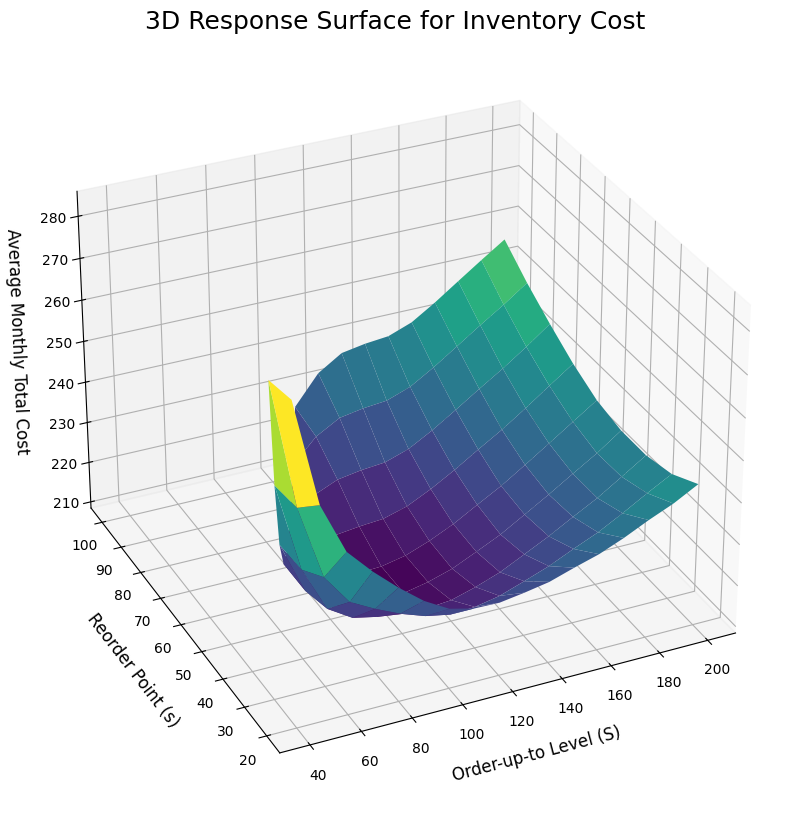

In [ ]:
# If 'all_experiment_results' is not populated with simulation runs we can also read from the csv files.
# For example:
# all_experiment_results[10] = pd.read_csv("results_rep_10.csv")
# all_experiment_results[1000] = pd.read_csv("results_rep_1000.csv")

# Generate plots for the 1000-replication experiment
num_reps_to_plot = 100

print(f"--- Generating 3D Response Surface Plot for the {num_reps_to_plot}-replication experiment ---")

if num_reps_to_plot in all_experiment_results:
    plot_3D_surface(all_experiment_results, num_reps_to_plot)
else:
    print(f"No data available for {num_reps_to_plot} replications.")